## Tutorial #4: Applying Machine Learning Methods to EEG Data on Participant Level

In this tutorial, machine learning methods that are commonly preferred for EEG analysis will be discussed. Additionally different techinques for approaching a classification problem on eeg data of 1 participant will be demonstrated. 

##### Dataset:
As the dataset for this tutorial, 'Emotion-Antecedent Appraisal Checks:
EEG and EMG data sets for Novelty and Pleasantness' selected. In this dataset, there are 26 participants, each have varying number of trials. There are three main categories as Target, Novel and Familar. Athough 70% of all images are in familiar category, 20% of them belongs to novel category and the rest is Target, each category has equal portion of Pleasant, Unpleasant and Neutral color images. If an image among 'Pleasant' images is selected and if it is also familiar to the participant, then the trial that is conducted with this image have 'FP' (Familiar-Pleasant) label. 
Therefore, in total there are 6 categories in this dataset. However number of categories may be changed by combining trials with the same familiarity level or the same pleasantness level. 

Since familar images forms the 70% of the dataset, trials with familiar pictures will be used throughout this tutorial to analyse effects of stimuli with different pleasantness levels on eeg.

Note that, only one participant will be used in this tutorial.



##### Machine Learning Methods:
For modelling eeg data, there are three common methods: Support Vector Machines, Linear Discriminant Analysis and Logistic Regression. These methods will be employed for modeling two class problems. In the end, we will get 3 models per method.   

In [ ]:
# For elimiating warnings
import warnings
warnings.filterwarnings('ignore')

In [179]:
# Load necessary libraries
import mne
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

As the first step, load epoch data from file. Please note that originally, this dataset is given in csv file. However it cannot be used directly as it is with MNE library. Therefore, if you want to proceed this tutorial, firstly go through the tutorial named 'study1'. 

In [180]:
data_file = '../../study1/study1_eeg/epochdata/P-01'

# Read the EEG epochs:
epochs = mne.read_epochs(data_file + '.fif')
print(len(epochs))

Reading ../../study1/study1_eeg/epochdata/P-01.fif ...
    Found the data of interest:
        t =       0.00 ...    1496.09 ms
        0 CTF compensation matrices available


<ipython-input-180-a55ec86bce5e>:4: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(data_file + '.fif')


484 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
484


In [181]:
epochs.event_id

{'FU': 0, 'FN': 1, 'FP': 2, 'NN': 3, 'NP': 4, 'NU': 5}

Keep familiar events only. Among FU, FN and FP events, create datasets with all possible event type pairs to build models for binary classification.

In [182]:
epochs_UN = epochs['FU', 'FN']
epochs_UP = epochs['FU', 'FP']
epochs_NP = epochs['FN', 'FP']

### Task #1:  Classification between Unpleasant and Neutral Events

Get data and the label for the dataset with unpleasant and neutral events.

In [183]:
# Dataset with unpleasant and neutral events
data_UN = epochs_UN.get_data()
labels_UN = epochs_UN.events[:,-1]

Split dataset into two sub-datasets as training set and test set with 70 - 30 ratio. 

In [184]:
train_data_UN, test_data_UN, labels_train_UN, labels_test_UN = train_test_split(data_UN, labels_UN, test_size=0.3, random_state=42)

Construct the pipeline with make_pipeline() function of sklearn library. The steps should be defined in the order of execution. Apart from the classifier, Vectorizer() and StandardScaler() will be used. The purpose of using Vectorizer is to convert eeg data from (n_epochs, n_channels, n_times) structure to a vector of (samples x channels) form. 

After having vectorized data, StandardScaler standardizes data feature-wise by following standard score technique which has the formulation of z = (x - u) / s. In this formula, u is the mean of the feature and s is the standard deviation of the same feature. By applying this technique, each feature's mean and standard deviation will become zero and one respectively. Standardization of features, which are eeg channels in our case, prevent domination of a channel(or a feature) just becuase it contains larger variation.

The final parameter of make_pipeline() will be the machine learning model. In the folowing example, the selected model is support vector machine model with rbf kernel and penalty parameter C=1. 

In [185]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))

If the hyperparameters for the classifier is determined in advance, they can be directly fixed as in above cell. However, usually it is quite difficult to determine optimal hyperparameters before testing different values for each parameter. If we test each parameter manually, we end up with another issue named overfitting. In such a case we would train the classifier with training set and test the performance on test set. So, we optimized parameters on the test set. In general, test set is smaller that training set and it may change when the trained classifier is being started to use in real systems. Therefore, having an overfitted model to test set would not provide a good generalization. 

For this problem cross validation would be a solution. In this approach, training set is devided into equally sized folds and trials run on different folds. In this way, hypeparameters will not be optimized on just one dataset, instead different chuncks of data will be used for hyperparameter optimization. Note that, at each trial one fold will be excluded from the training set and excluded fold will be used as test set during evaluation.

For cross validation, sklearn libarary has a method cross_val_score which runs cross validation and calculates and returns the accuracy of each fold. Number of folds is parameter for this function but as a heuristic, the 5-fold or 10-fold cross validation is preferred. 

In [186]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))
scores = cross_val_score(clf_svm_0, data_UN, labels_UN, cv=5)
for i in range(len(scores)):   
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]) + '\n')

Accuracy of 1th fold is 0.6470588235294118

Accuracy of 2th fold is 0.64

Accuracy of 3th fold is 0.76

Accuracy of 4th fold is 0.6326530612244898

Accuracy of 5th fold is 0.673469387755102



Another option is GridSearchCV which searchs the best performing parameters among the given list of possible parameter values exhaustedly. You can specify the scoring method and cross validation strategy inside GridSearchCV. In the following example StratifiedKFold strategy is selected. The benefit of using this stratefy is that it divides data into folds with approxiamtely same percentage of classes as the whole dataset.

In [187]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)

Train the classifier by passing training data and thier labels to fit() function. 

In [188]:
gs_cv_svm.fit(train_data_UN, labels_train_UN)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.7011494252873564


Finally, evaluate the model on test set. With classification_report function you are able to get precision, recall, f1-score and accuracy at the same time. If you want to have accuracy or other metrics separately, you can directly use sklearn's accuracy_score() or precision_recall_fscore_support() functions. If you use precision_recall_fscore_support() with average='macro' parameter, it calculates each metric by averaging all classes without weights.

In [189]:
#Prediction
predictions_svm = gs_cv_svm.predict(test_data_UN)

#Evaluate
report_svm = classification_report(labels_test_UN, predictions_svm, target_names=['Unpleasant', 'Neutral'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_UN, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_UN,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

SVM Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.79      0.59      0.68        37
     Neutral       0.68      0.84      0.75        38

    accuracy                           0.72        75
   macro avg       0.73      0.72      0.71        75
weighted avg       0.73      0.72      0.72        75

Accuracy of SVM model: 0.72
Precision: 0.7332826747720365, Recall: 0.7183499288762447, f1-score:0.7149321266968326


The same steps can be applied to train any other machine learning models.

The example above classifies unpleasant and neutral events with SVM. In the following cells, Logistic Regression and LDA will be built for the same classification task and then, performance of three different models will be compared.

In [190]:
# Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_UN, labels_train_UN)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(test_data_UN)

#Evaluation
report_lr = classification_report(labels_test_UN, predictions_lr, target_names=['Unpleasant', 'Neutral'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_UN, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_UN,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklear

Best Parameters: {'logisticregression__penalty': 'l1'}
Best Score: 0.7471264367816092
LR Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.74      0.62      0.68        37
     Neutral       0.68      0.79      0.73        38

    accuracy                           0.71        75
   macro avg       0.71      0.71      0.70        75
weighted avg       0.71      0.71      0.70        75

Accuracy of LR model: 0.7066666666666667
Precision: 0.7118768328445748, Recall: 0.705547652916074, f1-score:0.7040889526542324


In [191]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_UN,labels_train_UN)

#Predictions
predictions_lda = clf_lda_pip.predict(test_data_UN)

#Evaluation
report_lda = classification_report(labels_test_UN, predictions_lda, target_names=['Unpleasant', 'Neutral'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_UN, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_UN,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.76      0.68      0.71        37
     Neutral       0.71      0.79      0.75        38

    accuracy                           0.73        75
   macro avg       0.74      0.73      0.73        75
weighted avg       0.74      0.73      0.73        75

Accuracy of LDA model: 0.7333333333333333
Precision: 0.7359307359307359, Recall: 0.732574679943101, f1-score:0.7321428571428572


/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [192]:
accuracies, f1_scores = [], []
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

### Task #2:  Classification between Unpleasant and Pleasant Events

In [193]:
# Prepare dataset

In [194]:
# Dataset with unpleasant and pleasant events
data_UP = epochs_UP.get_data()
labels_UP = epochs_UP.events[:,-1]
train_data_UP, test_data_UP, labels_train_UP, labels_test_UP = train_test_split(data_UP, labels_UP, test_size=0.3, random_state=42)

Building SVM, LR and LDA models as in the first example.

In [195]:
# SVM
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)
gs_cv_svm.fit(train_data_UP, labels_train_UP)

print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

# Make prediction
predictions_svm = gs_cv_svm.predict(test_data_UP)
#Evaluation
report_svm = classification_report(labels_test_UP, predictions_svm, target_names=['Unpleasant', 'Pleasant'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_UP, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_UP,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.6703910614525139
SVM Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.53      0.58      0.55        31
    Pleasant       0.70      0.65      0.67        46

    accuracy                           0.62        77
   macro avg       0.61      0.62      0.61        77
weighted avg       0.63      0.62      0.63        77

Accuracy of SVM model: 0.6233766233766234
Precision: 0.6135430916552668, Recall: 0.6164095371669005, f1-score:0.6140017286084702


In [196]:
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_UP, labels_train_UP)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

# Prediction
predictions_lr = gs_cv_lr.predict(test_data_UP)

#Evaluation
report_lr = classification_report(labels_test_UP, predictions_lr, target_names=['Unpleasant', 'Pleasant'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_UP, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_UP,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklear

Best Parameters: {'logisticregression__penalty': 'l1'}
Best Score: 0.6983240223463687
LR Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.59      0.52      0.55        31
    Pleasant       0.70      0.76      0.73        46

    accuracy                           0.66        77
   macro avg       0.65      0.64      0.64        77
weighted avg       0.66      0.66      0.66        77

Accuracy of LR model: 0.6623376623376623
Precision: 0.6462962962962963, Recall: 0.6384992987377279, f1-score:0.6404454022988506


In [197]:
#LDA
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_UP,labels_train_UP)

#Prediction
predictions_lda = clf_lda_pip.predict(test_data_UP)

#Evaluation
report_lda = classification_report(labels_test_UP, predictions_lda, target_names=['Unpleasant', 'Plesant'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_UP, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_UP,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.56      0.58      0.57        31
     Plesant       0.71      0.70      0.70        46

    accuracy                           0.65        77
   macro avg       0.64      0.64      0.64        77
weighted avg       0.65      0.65      0.65        77

Accuracy of LDA model: 0.6493506493506493
Precision: 0.6368055555555556, Recall: 0.638148667601683, f1-score:0.6373626373626373


/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [198]:
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

### Task #3: Classification between Neutral and Pleasant Events

In [199]:
# Dataset with neutral and pleasant events
data_NP = epochs_NP.get_data()
labels_NP = epochs_NP.events[:,-1]
train_data_NP, test_data_NP, labels_train_NP, labels_test_NP = train_test_split(data_NP, labels_NP, test_size=0.3, random_state=42)

In [200]:
# SVM
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)
gs_cv_svm.fit(train_data_NP, labels_train_NP)

print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

# Prediction
predictions_svm = gs_cv_svm.predict(test_data_NP)

#Evaluation
report_svm = classification_report(labels_test_NP, predictions_svm, target_names=['Neutral', 'Pleasant'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_NP, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_NP,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'svc__C': 10, 'svc__kernel': 'sigmoid'}
Best Score: 0.5911602209944752
SVM Clasification Report:
               precision    recall  f1-score   support

     Neutral       0.72      0.67      0.70        43
    Pleasant       0.63      0.69      0.66        35

    accuracy                           0.68        78
   macro avg       0.68      0.68      0.68        78
weighted avg       0.68      0.68      0.68        78

Accuracy of SVM model: 0.6794871794871795
Precision: 0.6782894736842104, Recall: 0.6800664451827243, f1-score:0.678164713649117


In [201]:
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_NP, labels_train_NP)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

# Prediction
predictions_lr = gs_cv_lr.predict(test_data_NP)

#Evaluation
report_lr = classification_report(labels_test_NP, predictions_lr, target_names=['Neutral', 'Pleasant'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_NP, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_NP,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklear

Best Parameters: {'logisticregression__penalty': 'l1'}
Best Score: 0.6243093922651933
LR Clasification Report:
               precision    recall  f1-score   support

     Neutral       0.75      0.63      0.68        43
    Pleasant       0.62      0.74      0.68        35

    accuracy                           0.68        78
   macro avg       0.68      0.69      0.68        78
weighted avg       0.69      0.68      0.68        78

Accuracy of LR model: 0.6794871794871795
Precision: 0.6845238095238095, Recall: 0.6853820598006645, f1-score:0.6794344895610718


In [202]:
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_NP,labels_train_NP)

#Prediction
predictions_lda = clf_lda_pip.predict(test_data_NP)

#Evaluation
report_lda = classification_report(labels_test_NP, predictions_lda, target_names=['Neutral', 'Plesant'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_NP, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_NP,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

     Neutral       0.68      0.74      0.71        43
     Plesant       0.65      0.57      0.61        35

    accuracy                           0.67        78
   macro avg       0.66      0.66      0.66        78
weighted avg       0.66      0.67      0.66        78

Accuracy of LDA model: 0.6666666666666666
Precision: 0.6630061770761839, Recall: 0.6578073089700996, f1-score:0.6585858585858585


/Users/pinargoktepe/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [203]:
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

In order to demonstrate the accuracy values of all three tasks together, bar plot is employed as following:

In [204]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [215]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects1 = np.arange(len(evalMetric[:][0]))
    rects2 = [x + width for x in rects1]
    rects3 = [x + width for x in rects2]

    plt.bar(rects1, list(zip(*evalMetric))[0], color='#87CEFA', width=width, edgecolor='white', label=labels[0])
    plt.bar(rects2, list(zip(*evalMetric))[1], color='#FFE4E1', width=width, edgecolor='white', label=labels[1])
    plt.bar(rects3, list(zip(*evalMetric))[2], color='#CD5C5C', width=width, edgecolor='white', label=labels[2])

    plt.xlabel('Classification Tasks')
    plt.xticks([r + width for r in range(len(evalMetric[:][0]))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

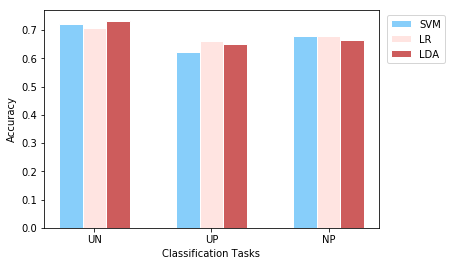

In [216]:
#Plot Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['SVM', 'LR', 'LDA']
plotEvalMetrics(tasks, labels, accuracies, 'Accuracy')

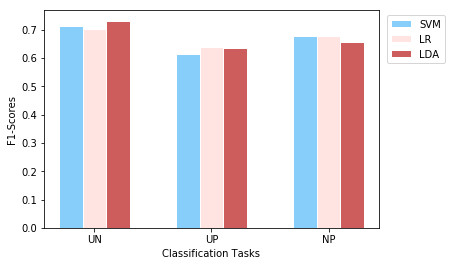

In [217]:
#Plot F1 Scores
tasks = ['UN', 'UP', 'NP']
labels = ['SVM', 'LR', 'LDA']
plotEvalMetrics(tasks, labels, f1_scores, 'F1-Scores')

### Results

On participant with id P01 data SVM, three different tasks are tested and for that, Logistic Regression (LR) and Linear Discriminant Analysis (LDA) models are built. The test accuracy values obtained from the models are provided  in the first plot above. According to the results, LDA provided the best perfromance on the first task which is classification of unpleasant and neutral events. For classification of unpleasant and pleasant events, logistic regression is the best performing model by surpassing LDA slightly. For the third task that classifies neutraland pleasant events, accuracy values are very similar. Although till now it is mentioned that certain models performed better on certain tasks, anyone could not reach above 75%.   

Although accuracy is one of the most common evaluation metrics for machine learning models, it is not enough to conclude a model is performing than another. It may be deceptive in some cases. For example when a model classifies a majority of the instances to one class, accuracy can still be high if the classes are highly imbalanced. Another case would be when false postive and false negative have different consequences. Especially in medical domain, this case an important aspect while evaluating models. Therefore, precision, recall and f1-score, which is a metric combining precision and recall, should be considered besides accuracy. 

F1-scores plot (second plot) demonstrates result similar to accuracy plot. So, it cannot be said that one model performing the best on all tasks and for all metrics that we calculated, values do not vary a lot. 